In [1]:
import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt
from iris.util import unify_time_units, equalise_attributes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data_path = "/net/spice/scratch/hadhy/impactstoolbox/Data/era5/Copernicus/*.nc"
cubes = iris.load(data_path, 'fdimrk')

# Select the time period
constraint = iris.Constraint(time=lambda cell: 1986 <= cell.point.year <= 2005)
filtered_cubes = [cube.extract(constraint) for cube in cubes]

In [3]:
ffdi_cubes = iris.cube.CubeList([cube for cube in filtered_cubes if isinstance(cube, iris.cube.Cube)])

for attr in ['history', 'source', 'institution', 'Conventions', 'references', 'comment']:
    for fc in ffdi_cubes:
        if attr in fc.attributes:
            fc.attributes.pop(attr)

unify_time_units(ffdi_cubes)
equalise_attributes(ffdi_cubes)
ffdi_cube = ffdi_cubes.concatenate_cube()

# Add a year coordinate to the cube
iris.coord_categorisation.add_year(ffdi_cube, 'time', name='year')

In [4]:
ffdi_cube

<iris 'Cube' of Fire danger index (as defined by the Australian forest service) / (unknown) (forecast_reference_time: 7305; latitude: 721; longitude: 1440)>

In [6]:
[coord.name() for coord in ffdi_cube.coords()]

['forecast_reference_time',
 'latitude',
 'longitude',
 'forecast_period',
 'original GRIB coordinate for key: level(surface)',
 'time',
 'year']

In [9]:

result = ffdi_cube.collapsed('time', iris.analysis.COUNT, function=lambda values: values >= 24) / 20

In [10]:
result

<iris 'Cube' of unknown / (1) (latitude: 721; longitude: 1440)>

In [12]:
def periodConstraint(cube, t1, t2):
    # Constrains the cube according to min and max datetimes
    def make_time_func(t1m, t2m):
        def tfunc(cell):
            return t1m <= cell.point <= t2m
        return tfunc
    tfunc = make_time_func(t1, t2)
    tconst = iris.Constraint(time=tfunc)
    ocube = cube.extract(tconst)
    return(ocube)


def getData(varname, start=None, end=None):

    path = '/project/LandCoverCCI/V2/Burned/Data/'
    yrfiles = path + '*/*.nc'
    cubes = iris.load(yrfiles, varname)
    equalise_attributes(cubes)
    cube = cubes.concatenate_cube()
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    if start and end:
        ocube = periodConstraint(cube, start, end)
    else:
        ocube = cube

    return ocube

In [14]:
import datetime as dt
start, end = [dt.datetime(1986, 1, 1), dt.datetime(2005, 12, 31)]
burnable = getData('fraction of burnable area', start=start, end=end)


In [22]:
print(burnable.coord('time'))

DimCoord :  time / (days since 1970-01-01 00:00:00, standard calendar)
    points: [
        2001-01-01 00:00:00, 2001-02-01 00:00:00, ...,
        2005-11-01 00:00:00, 2005-12-01 00:00:00]
    bounds: [
        [2001-01-01 00:00:00, 2001-01-31 00:00:00],
        [2001-02-01 00:00:00, 2001-02-28 00:00:00],
        ...,
        [2005-11-01 00:00:00, 2005-11-30 00:00:00],
        [2005-12-01 00:00:00, 2005-12-31 00:00:00]]
    shape: (60,)  bounds(60, 2)
    dtype: float64
    standard_name: 'time'
    long_name: 'time'
    var_name: 'time'


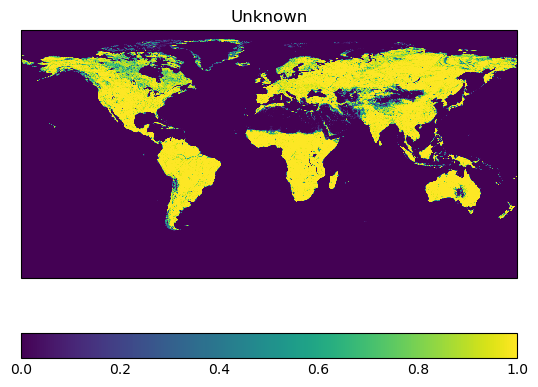

In [20]:
burnable_tot = burnable.collapsed('time', iris.analysis.SUM) / len(burnable.coord('time').points)
qplt.pcolormesh(burnable_tot)

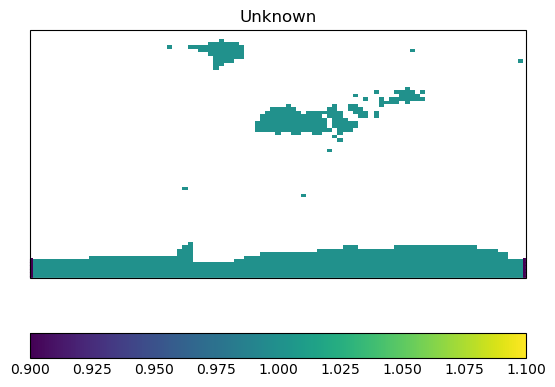

In [15]:
mask = iris.load_cube('/net/home/h02/hadhy/PycharmProjects/fire_paper/SAGE_bare_soil_ice_mask_regrid_gt50.pp')
qplt.pcolormesh(mask)

In [29]:
import numpy.ma as ma
# Mask not burnable
burnable_regridded = burnable_tot.regrid(result, iris.analysis.Linear())
masked_result = result.copy()
masked_result.data = ma.masked_where(burnable_regridded.data < 1, masked_result.data)

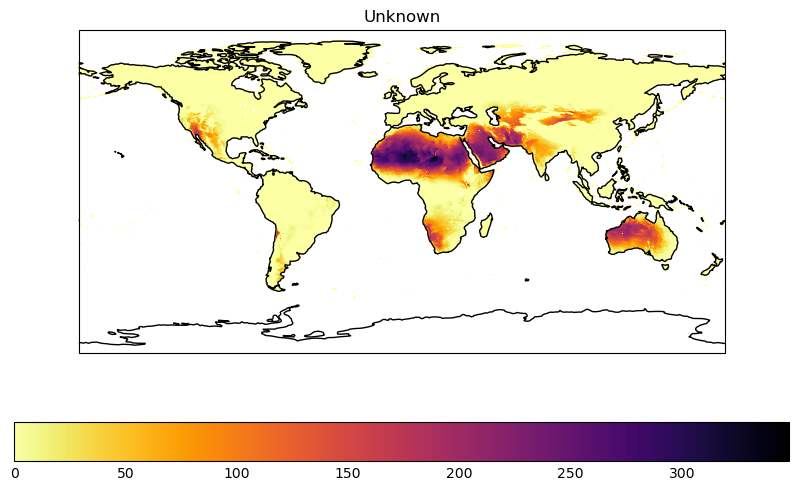

In [43]:
# Plot the global map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
qplt.pcolormesh(result, cmap='inferno_r', axes=ax)
# qplt.pcolormesh(mask, cmap='binary', axes=ax)
plt.gca().coastlines()
plt.show()

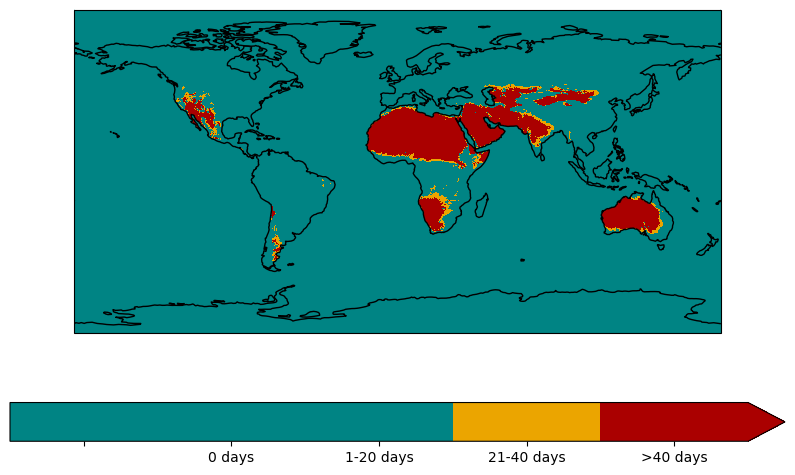

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import iris.quickplot as qplt

# Define bins for the categories
bins = [-np.inf, 0, 20, 40, np.inf]

# Digitize the data to get the bin indices
result_digitized = np.digitize(result.data, bins)

# Create a new cube for the digitized data
result_digitized_cube = result.copy(data=result_digitized)

# Define a colormap for the categories
# cmap = plt.get_cmap('viridis', len(bins) - 1)
mycolours = [(0, 0.518, 0.518), (0.941, 0.824, 0), (0.902, 0.471, 0), (0.667, 0, 0)]
cmap = colors.LinearSegmentedColormap.from_list('ffdi_colours', mycolours, N=len(bins))

# Define the colorbar labels
cbar_labels = ['', '0 days', '1-20 days', '21-40 days', '>40 days']

# Mask the digitised cube
# result_digitized_cube.data = ma.masked_where(burnable_regridded.data < 1, result_digitized_cube.data)

# Plot the global map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = iplt.pcolormesh(result_digitized_cube, cmap=cmap, axes=ax)
plt.gca().coastlines()

# Add a colorbar with the defined labels
cbar = plt.colorbar(mesh, ticks=range(len(bins)), boundaries=np.arange(-0.5, len(bins), 1), orientation='horizontal', extend='max')
cbar.ax.set_xticklabels(cbar_labels)

plt.show()